# Ceramic Dataset
## Define functions and imports

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
from skimage import io
from skimage import filters
import glob
import spectral.io.envi as envi
import numpy as np
import cv2
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
from matplotlib.lines import Line2D
DebugMode = True

In [3]:
def openHDR(hdrImage, mainImage, mask, window, hdrImageBlack, hdrImageWhite, usePaperCalibration = False):
    img = envi.open(hdrImage)#, mainImage
    Darkref = envi.open(hdrImageBlack)
    Whiteref = envi.open(hdrImageWhite)

    Darkref = np.repeat(Darkref[:,:,:],10, axis=0)
    Whiteref = np.repeat(Whiteref[:,:,:],10, axis=0)
    imgArray = img[:,:,:]
    print(type(imgArray[0,0,0]))
    Image = imgArray[np.nonzero(mask)]
    Dark = Darkref[np.nonzero(mask)]
    White = Whiteref[np.nonzero(mask)]
    Reflectancia = ((Image - Dark)/(White - Dark ))
    print(type(Reflectancia[0,0]))
    Reflectancia = Reflectancia.reshape(-1, Reflectancia.shape[-1])
    histogramMean = None
    histogramStd = None
    if usePaperCalibration:
        histogramMean = ([np.mean(Reflectancia[:,x]/paperMean[x]) for x in range(Reflectancia.shape[1])],img.bands.centers)
        histogramStd = [np.std(Reflectancia[:,x]/paperMean[x]) for x in range(Reflectancia.shape[1])]
    else:
        histogramMean = ([np.mean(Reflectancia[:,x]) for x in range(Reflectancia.shape[1])],img.bands.centers)
        histogramStd = [np.std(Reflectancia[:,x]) for x in range(Reflectancia.shape[1])]
    return histogramMean, histogramStd, Reflectancia#,paperMean,paperStd

In [23]:
def getMaskPieces(hsvImage,otsu):
    print(DebugMode)
    #Bare ceramic
    mask = np.maximum(hsvImage[:,:,0]<40,hsvImage[:,:,0]>170)
    #mask *= hsvImage[:,:,2]>otsu*0.2
    #mask *= hsvImage[:,:,2]<otsu*0.75
    mask *= hsvImage[:,:,1]>40
    mask[:,:110] = 0
    mask[:,475:] = 0
    if DebugMode:
        print("Base bare ceramic")
        plt.imshow(mask)
        plt.show()
    
    kernel = np.ones((7,7),np.uint8)
    mask = cv2.morphologyEx(np.float32(mask), cv2.MORPH_CLOSE, kernel)
    kernel = np.ones((5,5),np.uint8)
    #mask = cv2.morphologyEx(np.float32(mask), cv2.MORPH_OPEN, kernel)
    #kernel = np.ones((3,3),np.uint8)
    mask = cv2.morphologyEx(np.float32(mask), cv2.MORPH_ERODE, kernel)
    
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    
    
    if DebugMode:
        print("bare ceramic")
        plt.imshow(mask)
        plt.show()
        
    #Remove Stickers
    stickerMask = hsvImage[:,:,0]>170
    if DebugMode:
        print("first sticker pass")
        plt.imshow(stickerMask, vmin=0, vmax=1)
        plt.show()
    stickerMask *= hsvImage[:,:,1]>160
    stickerMask *= hsvImage[:,:,1]<210
    if DebugMode:
        print("first sticker pass")
        plt.imshow(stickerMask, vmin=0, vmax=1)
        plt.show()
        print(rmin, rmax)
    stickerMask *= hsvImage[:,:,2]>140
    #stickerMask *= hsvImage[:,:,2]<175
    stickerMask[:,:110] = 0
    stickerMask[:,475:] = 0
    stickerMask[:max(rmin-5,0),:] = 0
    stickerMask[rmax+5:,:] = 0
    if DebugMode:
        print("first sticker pass")
        plt.imshow(stickerMask, vmin=0, vmax=1)
        plt.show()
        print(rmin, rmax)
        
    kernel = np.ones((7,7),np.uint8)
    stickerMask = cv2.morphologyEx(np.float32(stickerMask), cv2.MORPH_OPEN, kernel)
    inverseStickerMask = 1-stickerMask
    kernel = np.ones((7,7),np.uint8)
    inverseStickerMask = cv2.morphologyEx(np.float32(inverseStickerMask), cv2.MORPH_ERODE, kernel)
    mask *= inverseStickerMask
    
    if DebugMode:
        print("first sticker pass")
        plt.imshow(stickerMask, vmin=0, vmax=1)
        plt.show()
        plt.imshow(inverseStickerMask, vmin=0, vmax=1)
        plt.show()
        plt.imshow(mask)
        plt.show()
        
    stickerMask = hsvImage[:,:,0]>22
    stickerMask *= hsvImage[:,:,0]<35
    stickerMask *= hsvImage[:,:,1]>60
    stickerMask *= hsvImage[:,:,1]<90
    stickerMask *= hsvImage[:,:,2]>150
    #stickerMask *= hsvImage[:,:,2]<175
    stickerMask[:,:110] = 0
    stickerMask[:,475:] = 0
    stickerMask[:rmin-5,:] = 0
    stickerMask[rmax+5:,:] = 0
    inverseStickerMask = 1-stickerMask
    kernel = np.ones((7,7),np.uint8)
    inverseStickerMask = cv2.morphologyEx(np.float32(inverseStickerMask), cv2.MORPH_ERODE, kernel)
    mask *= inverseStickerMask
    kernel = np.ones((5,5),np.uint8)
    mask = cv2.morphologyEx(np.float32(mask), cv2.MORPH_OPEN, kernel)
    
    if DebugMode:
        print("second sticker pass")
        plt.imshow(stickerMask, vmin=0, vmax=1)
        plt.show()
        plt.imshow(inverseStickerMask, vmin=0, vmax=1)
        plt.show()
        plt.imshow(mask)
        plt.show()
        
    #Ceramic Black Glaze
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    rmax = min(rmax, rmin+300)
    mask[rmax:] = 0
    glazeMask = hsvImage[:,:,2]<otsu
    glazeMask *= hsvImage[:,:,1]<150#np.maximum(hsvImage[:,:,1]<150,hsvImage[:,:,1]>45)
    kernel = np.ones((7,7),np.uint8)
    glazeMask = cv2.morphologyEx(np.float32(glazeMask), cv2.MORPH_CLOSE, kernel)
    glazeMask[:,:110] = 0
    glazeMask[:,475:] = 0
    glazeMask[:rmin-5,:] = 0
    glazeMask[rmax+5:,:] = 0
    
    if DebugMode:
        print("glaze mask")
        plt.imshow(glazeMask)
        plt.show()
    #mix Adjustments
    totalMask = np.maximum(glazeMask,mask)
    kernel = np.ones((9,9),np.uint8)
    totalMask = cv2.morphologyEx(np.float32(totalMask), cv2.MORPH_OPEN, kernel)
    
    if DebugMode:
        print("total mask")
        plt.imshow(totalMask)
        plt.show()
    
    #Remove Paper
    paperMask = hsvImage[:,:,2]>otsu*1.2
    paperMask *= hsvImage[:,:,1]<40
    kernel = np.ones((7,7),np.uint8)
    paperMask = cv2.morphologyEx(np.float32(paperMask), cv2.MORPH_CLOSE, kernel)
    inversePaperMask = 1-paperMask
    kernel = np.ones((5,5),np.uint8)
    inversePaperMask = cv2.morphologyEx(np.float32(inversePaperMask), cv2.MORPH_OPEN, kernel)
    totalMask *= inversePaperMask
    
    if DebugMode:
        print("paper pass")
        plt.imshow(totalMask)
        plt.show()
    
    #Remove Plasticine
    plastMask = hsvImage[:,:,0]>80
    plastMask *= hsvImage[:,:,0]<110
    plastMask *= hsvImage[:,:,1]>150
    plastMask[:,:110] = 0
    plastMask[:,475:] = 0
    plastMask[:rmin-5,:] = 0
    plastMask[rmax+5:,:] = 0
    inversePlastMask = 1-plastMask
    kernel = np.ones((5,5),np.uint8)
    inversePlastMask = cv2.morphologyEx(np.float32(inversePlastMask), cv2.MORPH_CLOSE, kernel)
    totalMask *= inversePlastMask
    
    if DebugMode:
        print("plasticine pass")
        plt.imshow(totalMask)
        plt.show()
    
    
    
    #Shadow Pass
    shadowMask = hsvImage[:,:,2]>otsu*0.5
    shadowMask *= hsvImage[:,:,2]<otsu*1.2
    shadowMask *= hsvImage[:,:,1]<50
    kernel = np.ones((7,7),np.uint8)
    shadowMask = cv2.morphologyEx(np.float32(shadowMask), cv2.MORPH_CLOSE, kernel)
    shadowMask[:,:110] = 0
    shadowMask[:,475:] = 0
    shadowMask[:rmin-5,:] = 0
    shadowMask[rmax+5:,:] = 0
    inverseShadowMask = 1-shadowMask
    #totalMask *= inverseShadowMask

    
    '''fig, (ax1) = plt.subplots(figsize=(15,15))
    ax1.imshow(mask)
    plt.show()
    fig, (ax1) = plt.subplots(figsize=(15,15))
    ax1.imshow(glazeMask)
    plt.show()
    fig, (ax1) = plt.subplots(figsize=(15,15))
    ax1.imshow(inversePaperMask)
    plt.show()'''
    return totalMask
    

In [5]:
def openAndCrop(folderPath, paperWindow=7, window = 5, usePaperCalibration = True, showImages=True):#, corners, paperTopLeft, paperBottomRight
    imagePath = glob.glob(folderPath+'Im*.png')[0].replace('\\','/')
    hdrImage = glob.glob(folderPath+'*capture/*.hdr')[1].replace('\\','/')
    hdrImageBlack = glob.glob(folderPath+'*capture/*.hdr')[0].replace('\\','/')
    hdrImageWhite = glob.glob(folderPath+'*capture/*.hdr')[2].replace('\\','/')
    image = io.imread(imagePath)
    
    
    hsvImage = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsvImage[:,:110,2] = 0
    hsvImage[:,475:,2] = 0
    otsu = filters.threshold_otsu(hsvImage[:,:,2])
    mask = getMaskPieces(hsvImage.copy(),otsu)
    
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    cropImage = image.copy()
    cropImage[np.nonzero(mask)] = [255,0,0]
    cropImage = cropImage[rmin-5:rmax+5,cmin-5:cmax+5]
    image2 = image.copy()[rmin-5:rmax+5,cmin-5:cmax+5]
    #histogram, std, values = openHDR(hdrImage, imagePath, mask, window, paperMask, paperWindow)#,paperMean,paperStd
    histogram, std, values = openHDR(hdrImage, imagePath, mask, window, hdrImageBlack, hdrImageWhite)#,paperMean,paperStd
    xValues = histogram[1]
    mean = np.array(histogram[0])
    std = np.array(std)
    
    if showImages:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, figsize=(9,3))
        ax1.imshow(image)
        ax2.imshow(cropImage)
        ax3.plot(xValues,mean)
        ax3.fill_between(xValues,mean-std, mean+std,alpha=0.2)
        ax3.set_ylim([0,1])
        ax3.set_xlabel("Wavelength(nm)")
        ax3.set_ylabel("Reflectance")
        
        ax1.set_anchor("S")
        ax2.set_anchor("S")
        ax3.set_anchor("S")
        
        
        
        fig.suptitle(folderPath.split('\\')[-1])
        #print(folderPath.split('\\'))
        plt.subplots_adjust(wspace = 0.4,bottom = 0.1)
        plt.show()
        fig, (ax1) = plt.subplots(figsize=(18,3))
        ax1.plot(xValues,mean)
        ax1.fill_between(xValues,mean-std, mean+std,alpha=0.2)
        ax1.set_ylim([0,1])
        ax1.set_xticks(np.arange(400, 1000, 20))
        ax1.set_xlabel("Wavelength(nm)")
        ax1.set_ylabel("Reflectance")
        plt.show()
        '''fig, (ax1) = plt.subplots(figsize=(9,9))
        ax1.imshow(cropImage)
        plt.show()
        fig, (ax1) = plt.subplots(figsize=(9,9))
        ax1.imshow(image2)
        plt.show()'''
         
    return [xValues, mean, std,values]

## Image Samples
Some samples from each category of ceramics are shown here, as a first step towards the visualization of differences between the histograms of different categories

0 ./ceramiques_3.0\g1\g1_01\g1_01_1A
1 ./ceramiques_3.0\g1\g1_01\g1_01_1B
2 ./ceramiques_3.0\g1\g1_01\g1_01_1C
3 ./ceramiques_3.0\g1\g1_02\g1_02_1A
4 ./ceramiques_3.0\g1\g1_02\g1_02_1B
5 ./ceramiques_3.0\g1\g1_02\g1_02_1C
6 ./ceramiques_3.0\g1\g1_03\g1_03_1A
7 ./ceramiques_3.0\g1\g1_03\g1_03_1B
8 ./ceramiques_3.0\g1\g1_03\g1_03_1C
9 ./ceramiques_3.0\g1\g1_04\g1_04_1A
10 ./ceramiques_3.0\g1\g1_04\g1_04_1B
11 ./ceramiques_3.0\g1\g1_04\g1_04_1C
12 ./ceramiques_3.0\g1\g1_05\g1_05_1A
13 ./ceramiques_3.0\g1\g1_05\g1_05_1B
14 ./ceramiques_3.0\g1\g1_05\g1_05_1C
15 ./ceramiques_3.0\g2\g2_01\g2_01_1A
16 ./ceramiques_3.0\g2\g2_01\g2_01_1B
17 ./ceramiques_3.0\g2\g2_01\g2_01_1C
18 ./ceramiques_3.0\g2\g2_02\g2_02_1A
19 ./ceramiques_3.0\g2\g2_02\g2_02_1B
20 ./ceramiques_3.0\g2\g2_02\g2_02_1C
21 ./ceramiques_3.0\g2\g2_03\g2_03_1A
22 ./ceramiques_3.0\g2\g2_03\g2_03_1B
23 ./ceramiques_3.0\g2\g2_03\g2_03_1C
24 ./ceramiques_3.0\g2\g2_04\g2_04_1A
25 ./ceramiques_3.0\g2\g2_04\g2_04_1B
26 ./ceramiques_3.0\g2

C:\Users\pcano\Anaconda3\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


<class 'numpy.uint16'>
<class 'numpy.float64'>


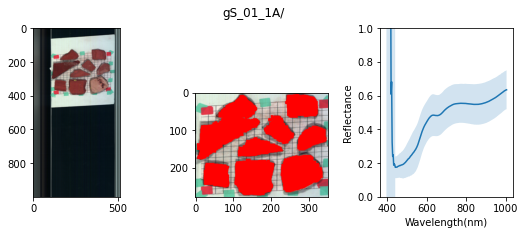

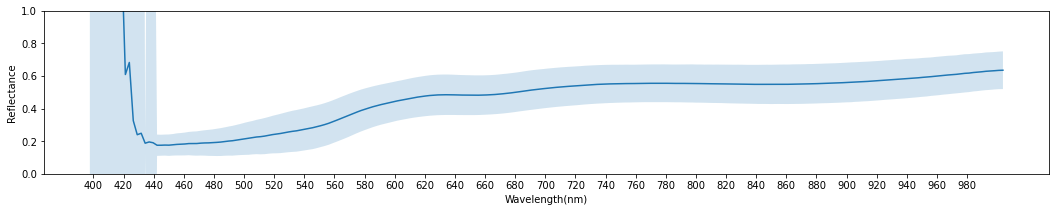

False


C:\Users\pcano\Anaconda3\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


<class 'numpy.uint16'>


<ipython-input-3-78fcf0bc1d27>:13: RuntimeWarning: divide by zero encountered in true_divide
  Reflectancia = ((Image - Dark)/(White - Dark ))
<ipython-input-3-78fcf0bc1d27>:13: RuntimeWarning: invalid value encountered in true_divide
  Reflectancia = ((Image - Dark)/(White - Dark ))


<class 'numpy.float64'>


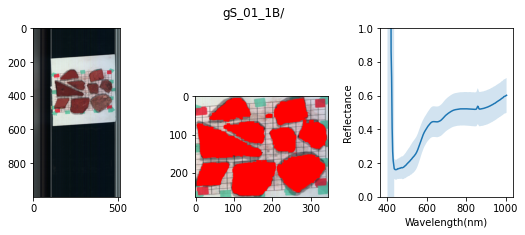

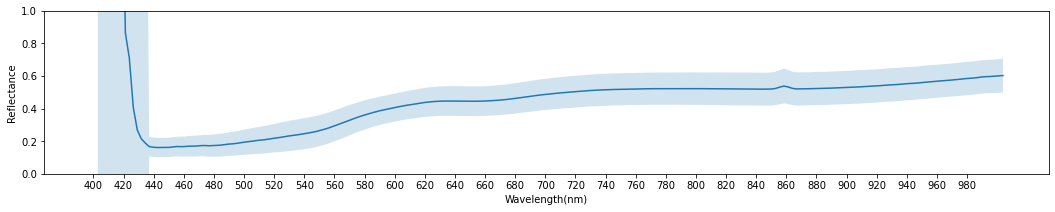

False


C:\Users\pcano\Anaconda3\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


<class 'numpy.uint16'>
<class 'numpy.float64'>


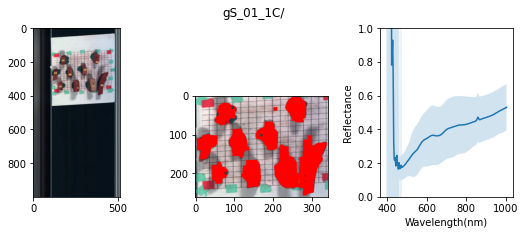

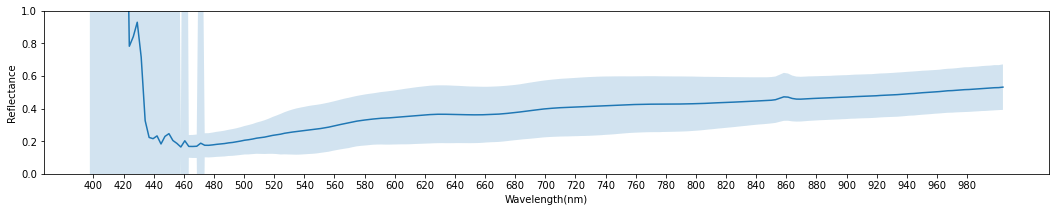

False


C:\Users\pcano\Anaconda3\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


<class 'numpy.uint16'>
<class 'numpy.float64'>


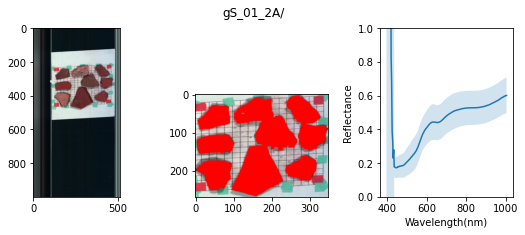

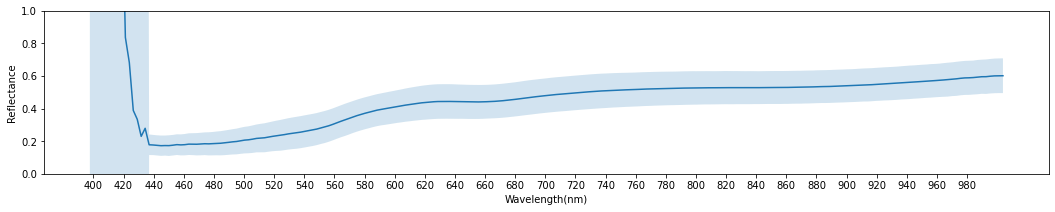

False


C:\Users\pcano\Anaconda3\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


<class 'numpy.uint16'>
<class 'numpy.float64'>


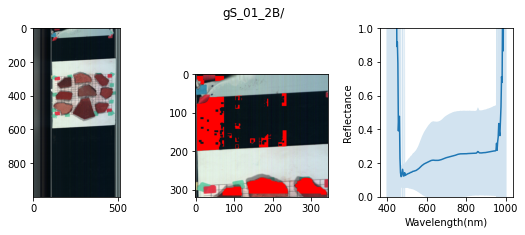

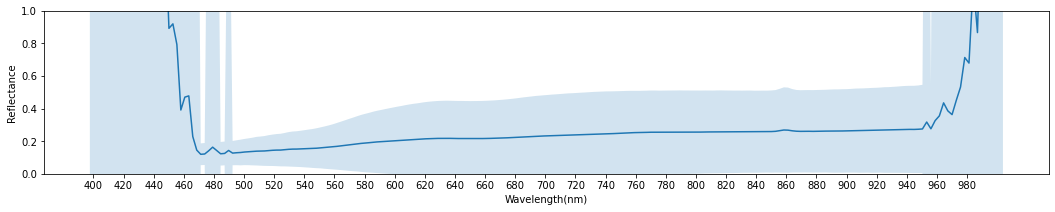

False


C:\Users\pcano\Anaconda3\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


<class 'numpy.uint16'>
<class 'numpy.float64'>


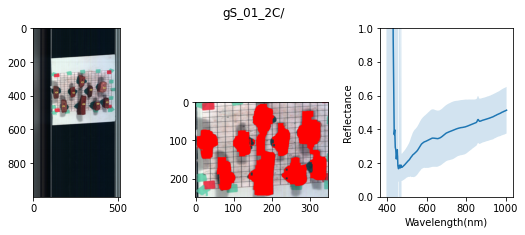

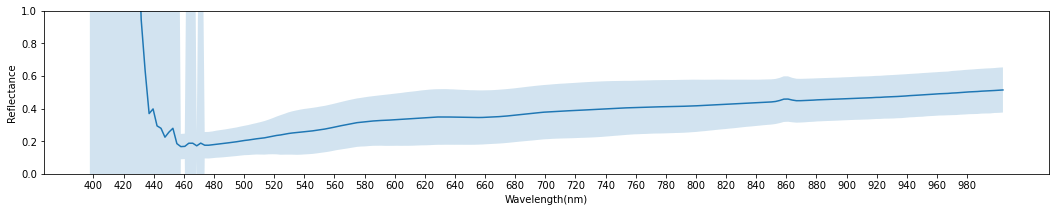

False


C:\Users\pcano\Anaconda3\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


<class 'numpy.uint16'>
<class 'numpy.float64'>


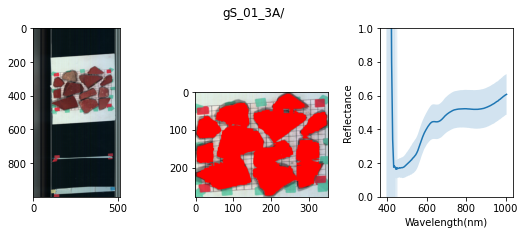

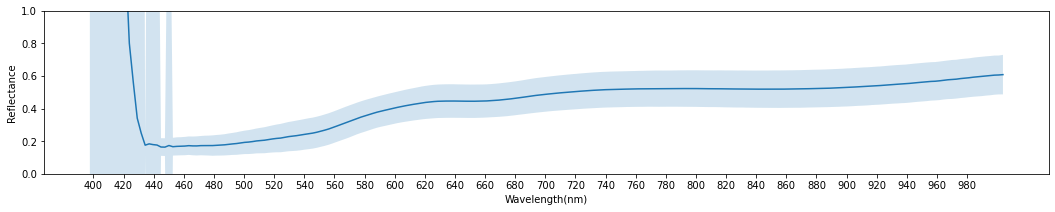

False


C:\Users\pcano\Anaconda3\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


<class 'numpy.uint16'>
<class 'numpy.float64'>


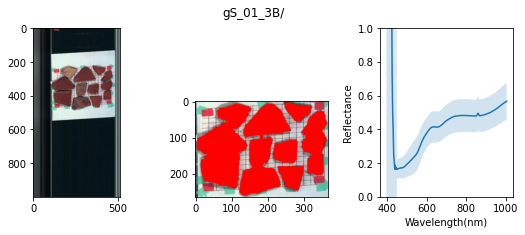

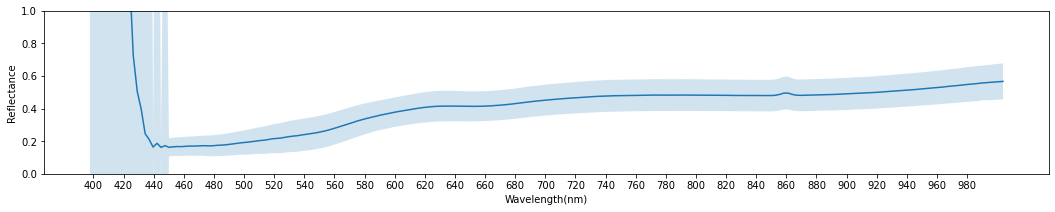

False


C:\Users\pcano\Anaconda3\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


<class 'numpy.uint16'>
<class 'numpy.float64'>


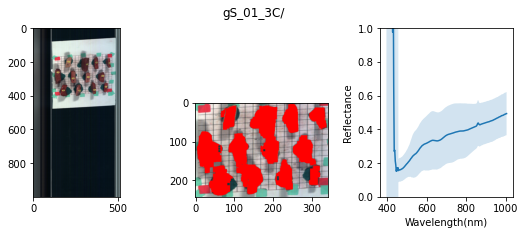

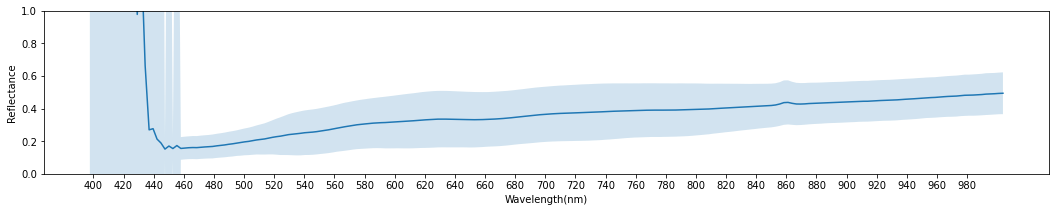

In [42]:
folders = glob.glob("./ceramiques_3.0/*/*/*")
for index in range(len(folders)):
    print(index, folders[index])
Start = 258
End = 267
DebugMode = False
for folder in folders[Start:End]:
    folder += "/"
    openAndCrop(folder)

True
Base bare ceramic


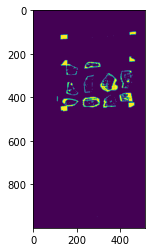

bare ceramic


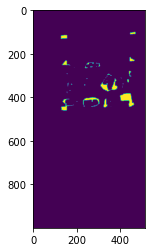

first sticker pass


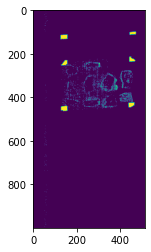

first sticker pass


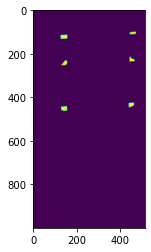

101 461
first sticker pass


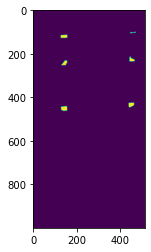

101 461
first sticker pass


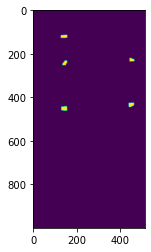

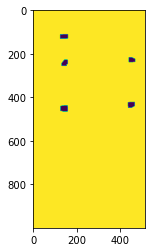

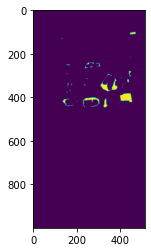

second sticker pass


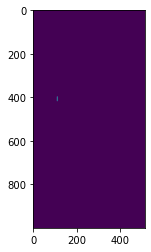

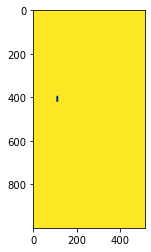

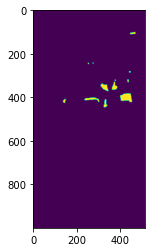

glaze mask


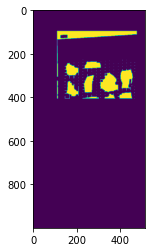

total mask


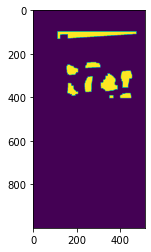

paper pass


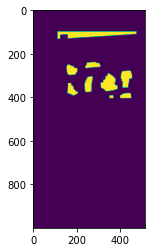

plasticine pass


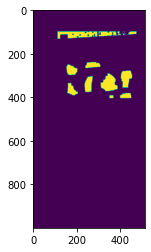

C:\Users\pcano\Anaconda3\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


<class 'numpy.uint16'>
<class 'numpy.float64'>


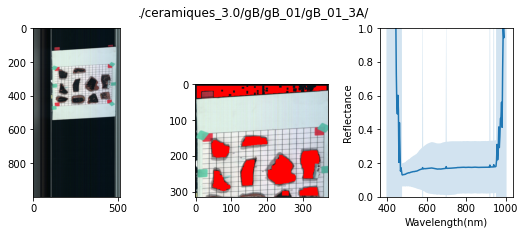

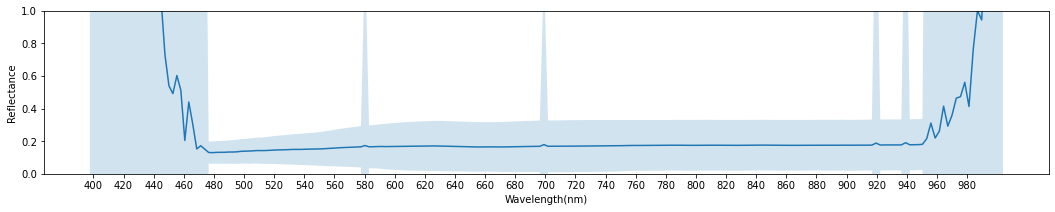

[[397.66,
  400.28,
  402.9,
  405.52,
  408.13,
  410.75,
  413.37,
  416.0,
  418.62,
  421.24,
  423.86,
  426.49,
  429.12,
  431.74,
  434.37,
  437.0,
  439.63,
  442.26,
  444.89,
  447.52,
  450.16,
  452.79,
  455.43,
  458.06,
  460.7,
  463.34,
  465.98,
  468.62,
  471.26,
  473.9,
  476.54,
  479.18,
  481.83,
  484.47,
  487.12,
  489.77,
  492.42,
  495.07,
  497.72,
  500.37,
  503.02,
  505.67,
  508.32,
  510.98,
  513.63,
  516.29,
  518.95,
  521.61,
  524.27,
  526.93,
  529.59,
  532.25,
  534.91,
  537.57,
  540.24,
  542.91,
  545.57,
  548.24,
  550.91,
  553.58,
  556.25,
  558.92,
  561.59,
  564.26,
  566.94,
  569.61,
  572.29,
  574.96,
  577.64,
  580.32,
  583.0,
  585.68,
  588.36,
  591.04,
  593.73,
  596.41,
  599.1,
  601.78,
  604.47,
  607.16,
  609.85,
  612.53,
  615.23,
  617.92,
  620.61,
  623.3,
  626.0,
  628.69,
  631.39,
  634.08,
  636.78,
  639.48,
  642.18,
  644.88,
  647.58,
  650.29,
  652.99,
  655.69,
  658.4,
  661.1,
  663.81,
 

In [22]:
DebugMode = True
openAndCrop("./ceramiques_3.0/gB/gB_01/gB_01_3A/")

In [118]:
histograms = []

C:\Users\pcano\Anaconda3\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


<class 'numpy.uint16'>
<class 'numpy.float64'>


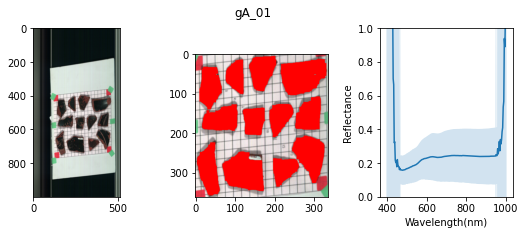

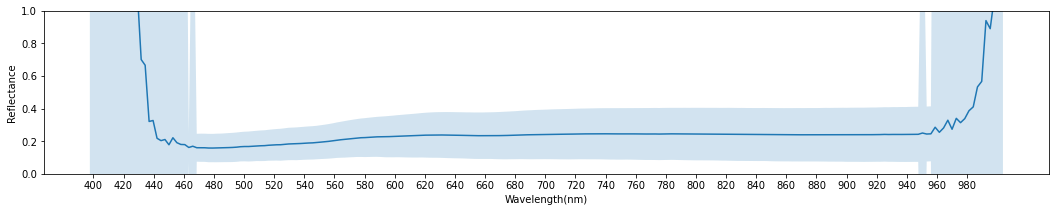

In [119]:
histograms.append(openAndCrop("./ceramiques_3.0/gA/gA_01/gA_01_1A/"))

bare ceramic


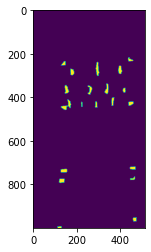

first sticker pass


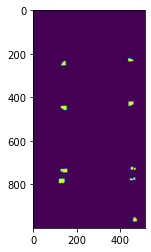

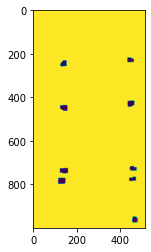

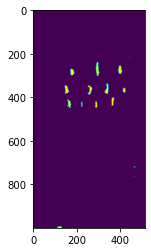

second sticker pass


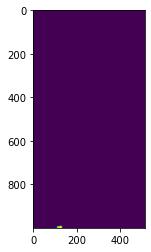

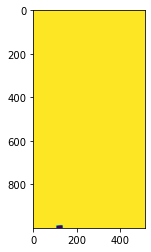

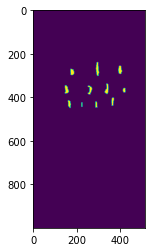

total mask


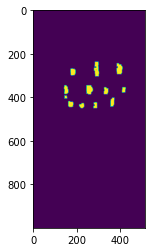

paper pass


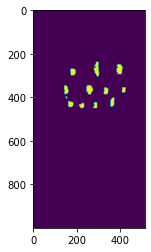

plasticine pass


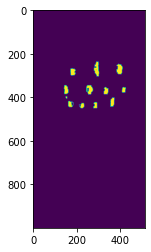

C:\Users\pcano\Anaconda3\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


<class 'numpy.uint16'>
<class 'numpy.float64'>


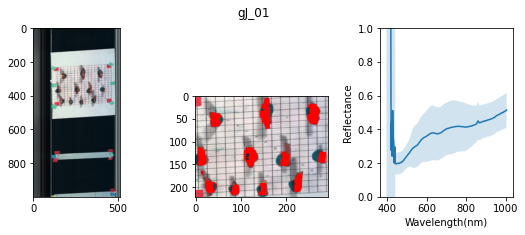

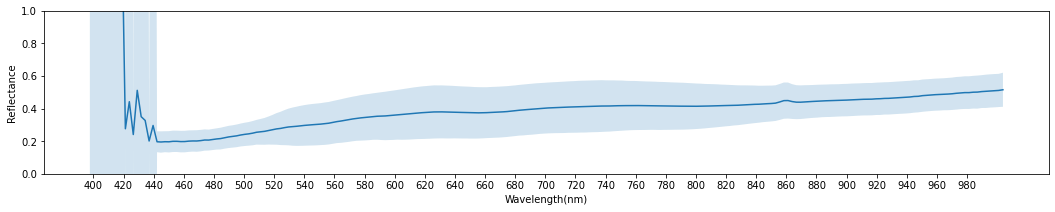

In [126]:
histograms.append(openAndCrop("./ceramiques_3.0/gJ/gJ_01/gJ_01_2C/"))

C:\Users\pcano\Anaconda3\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


<class 'numpy.uint16'>
<class 'numpy.float64'>


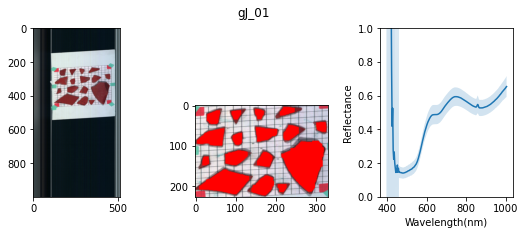

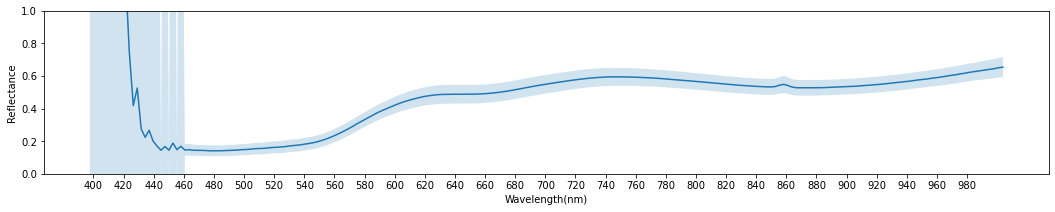

In [121]:
histograms.append(openAndCrop("./ceramiques_3.0/gJ/gJ_01/gJ_01_1B/"))

In [ ]:
histograms.append(openAndCrop("./ceramiques_3.0/gA/gA_01/gA_01_1C/"))

In [ ]:
histograms.append(openAndCrop("./ceramiques_3.0/gA/gA_01/gA_01_2A/"))

In [ ]:
histograms.append(openAndCrop("./ceramiques_3.0/gA/gA_01/gA_01_2B/"))

In [ ]:
histograms.append(openAndCrop("./ceramiques_3.0/gA/gA_01/gA_01_2C/"))

In [ ]:
histograms.append(openAndCrop("./ceramiques_3.0/gB/gB_01/gB_01_1A/"))

In [ ]:
histograms.append(openAndCrop("./ceramiques_3.0/gB/gB_01/gB_01_1B/"))

In [ ]:
histograms.append(openAndCrop("./ceramiques_3.0/gB/gB_01/gB_01_1C/"))

In [ ]:
histograms.append(openAndCrop("./ceramiques_3.0/gB/gB_01/gB_01_2A/"))

In [ ]:
histograms.append(openAndCrop("./ceramiques_3.0/gB/gB_01/gB_01_2B/"))

In [ ]:
histograms.append(openAndCrop("./ceramiques_3.0/gB/gB_01/gB_01_2C/"))

In [ ]:
histograms.append(openAndCrop("./ceramiques_3.0/gB/gB_01/gB_01_3A/"))

In [ ]:
histograms.append(openAndCrop("./ceramiques_3.0/gB/gB_01/gB_01_3B/"))

In [ ]:
histograms.append(openAndCrop("./ceramiques_3.0/gB/gB_01/gB_01_3C/"))

## Histogram comparison

In [ ]:
sigma = 2

In [ ]:
for romanHistogram in histograms[7:11]:
    plt.plot(romanHistogram[0],romanHistogram[1])
    plt.fill_between(romanHistogram[0],romanHistogram[1]-romanHistogram[2]*sigma,romanHistogram[1]+romanHistogram[2]*sigma, alpha = 0.2)
plt.title("Roman Ceramics Histograms Comparison")
plt.ylim([0,1])
plt.xlabel("Wavelength(nm)")
plt.ylabel("Reflectance")
plt.show()

In [ ]:
for modernHistogram in histograms[11:]:
    plt.plot(modernHistogram[0],modernHistogram[1])
    plt.fill_between(modernHistogram[0],modernHistogram[1]-modernHistogram[2]*sigma,modernHistogram[1]+modernHistogram[2]*sigma, alpha = 0.2)
plt.title("Modern Ceramics Histograms Comparison")
plt.ylim([0,1])
plt.xlabel("Wavelength(nm)")
plt.ylabel("Reflectance")
plt.show()

In [ ]:
for ancientHistogram in histograms[:2-1]:
    plt.plot(ancientHistogram[0],ancientHistogram[1],mcolors.TABLEAU_COLORS["tab:blue"])
    plt.fill_between(ancientHistogram[0],ancientHistogram[1]-ancientHistogram[2]*sigma,ancientHistogram[1]+ancientHistogram[2]*sigma, alpha = 0.2, color=mcolors.TABLEAU_COLORS["tab:blue"])
for ancientHistogram in histograms[2-1:2]:
    plt.plot(ancientHistogram[0],ancientHistogram[1],mcolors.TABLEAU_COLORS["tab:blue"],label="Ancient Ceramics")
    plt.fill_between(ancientHistogram[0],ancientHistogram[1]-ancientHistogram[2]*sigma,ancientHistogram[1]+ancientHistogram[2]*sigma, alpha = 0.2, color=mcolors.TABLEAU_COLORS["tab:blue"])
for ancientHistogram in histograms[2:3]:
    plt.plot(ancientHistogram[0],ancientHistogram[1],mcolors.TABLEAU_COLORS["tab:orange"],label="Tardoantiguitat")
    plt.fill_between(ancientHistogram[0],ancientHistogram[1]-ancientHistogram[2]*sigma,ancientHistogram[1]+ancientHistogram[2]*sigma, alpha = 0.2, color=mcolors.TABLEAU_COLORS["tab:orange"])
for ancientHistogram in histograms[3:4]:
    plt.plot(ancientHistogram[0],ancientHistogram[1],mcolors.TABLEAU_COLORS["tab:green"],label="Commune amphorae")
    plt.fill_between(ancientHistogram[0],ancientHistogram[1]-ancientHistogram[2]*sigma,ancientHistogram[1]+ancientHistogram[2]*sigma, alpha = 0.2, color=mcolors.TABLEAU_COLORS["tab:green"])
for ancientHistogram in histograms[4:5]:
    plt.plot(ancientHistogram[0],ancientHistogram[1],mcolors.TABLEAU_COLORS["tab:purple"],label="African commune ceramics")
    plt.fill_between(ancientHistogram[0],ancientHistogram[1]-ancientHistogram[2]*sigma,ancientHistogram[1]+ancientHistogram[2]*sigma, alpha = 0.2, color=mcolors.TABLEAU_COLORS["tab:purple"])
for ancientHistogram in histograms[5:6]:
    plt.plot(ancientHistogram[0],ancientHistogram[1],mcolors.TABLEAU_COLORS["tab:olive"],label="Local commune ceramics ")
    plt.fill_between(ancientHistogram[0],ancientHistogram[1]-ancientHistogram[2]*sigma,ancientHistogram[1]+ancientHistogram[2]*sigma, alpha = 0.2, color=mcolors.TABLEAU_COLORS["tab:olive"])
for ancientHistogram in histograms[6:7]:
    plt.plot(ancientHistogram[0],ancientHistogram[1],mcolors.TABLEAU_COLORS["tab:cyan"],label="Iberic")
    plt.fill_between(ancientHistogram[0],ancientHistogram[1]-ancientHistogram[2]*sigma,ancientHistogram[1]+ancientHistogram[2]*sigma, alpha = 0.2, color=mcolors.TABLEAU_COLORS["tab:cyan"])
for romanHistogram in histograms[7:11-1]:
    plt.plot(romanHistogram[0],romanHistogram[1],mcolors.TABLEAU_COLORS["tab:red"])
    plt.fill_between(romanHistogram[0],romanHistogram[1]-romanHistogram[2]*sigma,romanHistogram[1]+romanHistogram[2]*sigma, alpha = 0.2, color=mcolors.TABLEAU_COLORS["tab:red"])
for romanHistogram in histograms[11-1:11]:
    plt.plot(romanHistogram[0],romanHistogram[1],mcolors.TABLEAU_COLORS["tab:red"],label="Roman Ceramics")
    plt.fill_between(romanHistogram[0],romanHistogram[1]-romanHistogram[2]*sigma,romanHistogram[1]+romanHistogram[2]*sigma, alpha = 0.2, color=mcolors.TABLEAU_COLORS["tab:red"])
for modernHistogram in histograms[11:-1]:
    plt.plot(modernHistogram[0],modernHistogram[1],mcolors.TABLEAU_COLORS["tab:brown"])
    plt.fill_between(modernHistogram[0],modernHistogram[1]-modernHistogram[2]*sigma,modernHistogram[1]+modernHistogram[2]*sigma, alpha = 0.2, color=mcolors.TABLEAU_COLORS["tab:brown"])
for modernHistogram in histograms[-1:]:
    plt.plot(modernHistogram[0],modernHistogram[1],mcolors.TABLEAU_COLORS["tab:brown"],label="Modern Ceramics")
    plt.fill_between(modernHistogram[0],modernHistogram[1]-modernHistogram[2]*sigma,modernHistogram[1]+modernHistogram[2]*sigma, alpha = 0.2, color=mcolors.TABLEAU_COLORS["tab:brown"])
plt.title("Ceramics' Histograms Comparison")
plt.ylim([0,1])
plt.xlabel("Wavelength(nm)")
plt.ylabel("Reflectance")
plt.figlegend(loc='center left', bbox_to_anchor=(0.9, 0.5))
plt.show()

## Category Analysis

All the samples of each category are analyzed, and the resulting values aggregated by category, allowing a cleaner approach than using individual samples and histograms

In [ ]:
modernValues = np.empty((0,224))
romanValues = np.empty((0,224))
TardoAntiguitatValues = np.empty((0,224))
IberiquesValues = np.empty((0,224))
bands = openAndCrop("./Ceramica/g6/g6_01/1A/",showImages=False)[0]

In [ ]:

modernValues = np.empty((0,224))
#modernValues = np.concatenate((modernValues,openAndCrop("./Ceramica/g6/g6_01/1A/",showImages=False)[3]))
#modernValues = np.concatenate((modernValues,openAndCrop("./Ceramica/g6/g6_01/1B/",showImages=False)[3]))
modernValues = np.concatenate((modernValues,openAndCrop("./Ceramica/g6/g6_02/1A/",showImages=False)[3]))
modernValues = np.concatenate((modernValues,openAndCrop("./Ceramica/g6/g6_02/1B/",showImages=False)[3]))
modernValues = np.concatenate((modernValues,openAndCrop("./Ceramica/g6/g6_02/2A/",showImages=False)[3]))
modernValues = np.concatenate((modernValues,openAndCrop("./Ceramica/g6/g6_02/2B/",showImages=False)[3]))
modernValues = np.concatenate((modernValues,openAndCrop("./Ceramica/g6/g6_03/1A/",showImages=False)[3]))
#modernValues = np.concatenate((modernValues,openAndCrop("./Ceramica/g6/g6_03/1B/",showImages=False)[3]))
#modernValues = np.concatenate((modernValues,openAndCrop("./Ceramica/g6/g6_03/2A/",showImages=False)[3]))
#modernValues = np.concatenate((modernValues,openAndCrop("./Ceramica/g6/g6_03/2B/",showImages=False)[3]))
#modernValues = np.concatenate((modernValues,openAndCrop("./Ceramica/g6/g6_03/3A/",showImages=False)[3]))
#modernValues = np.concatenate((modernValues,openAndCrop("./Ceramica/g6/g6_03/3B/",showImages=False)[3]))

In [ ]:
romanValues = np.concatenate((romanValues,openAndCrop("./Ceramica/g4/g4_01/1A/",showImages=False)[3]))
romanValues = np.concatenate((romanValues,openAndCrop("./Ceramica/g4/g4_01/1B/",showImages=False)[3]))
romanValues = np.concatenate((romanValues,openAndCrop("./Ceramica/g4/g4_02/1A/",showImages=False)[3]))
romanValues = np.concatenate((romanValues,openAndCrop("./Ceramica/g4/g4_02/1B/",showImages=False)[3]))
romanValues = np.concatenate((romanValues,openAndCrop("./Ceramica/g4/g4_03/1A/",showImages=False)[3]))
romanValues = np.concatenate((romanValues,openAndCrop("./Ceramica/g4/g4_03/1B/",showImages=False)[3]))

In [ ]:
TardoAntiguitatValues = np.concatenate((TardoAntiguitatValues,openAndCrop("./Ceramica/g3/g3_01/1A/",showImages=False)[3]))
TardoAntiguitatValues = np.concatenate((TardoAntiguitatValues,openAndCrop("./Ceramica/g3/g3_01/1B/",showImages=False)[3]))

In [ ]:
#IberiquesValues = np.concatenate((IberiquesValues,openAndCrop("./Ceramica/g2/g2_01/1A/",showImages=False)[3]))
#IberiquesValues = np.concatenate((IberiquesValues,openAndCrop("./Ceramica/g2/g2_01/1B/",showImages=False)[3]))
#IberiquesValues = np.concatenate((IberiquesValues,openAndCrop("./Ceramica/g2/g2_02/1A/",showImages=False)[3]))
#IberiquesValues = np.concatenate((IberiquesValues,openAndCrop("./Ceramica/g2/g2_02/1B/",showImages=False)[3]))
IberiquesValues = np.concatenate((IberiquesValues,openAndCrop("./Ceramica/g2/g2_03/1A/",showImages=False)[3]))
IberiquesValues = np.concatenate((IberiquesValues,openAndCrop("./Ceramica/g2/g2_03/1B/",showImages=False)[3]))
IberiquesValues = np.concatenate((IberiquesValues,openAndCrop("./Ceramica/g2/g2_04/1A/",showImages=False)[3]))
IberiquesValues = np.concatenate((IberiquesValues,openAndCrop("./Ceramica/g2/g2_04/1B/",showImages=False)[3]))
IberiquesValues = np.concatenate((IberiquesValues,openAndCrop("./Ceramica/g2/g2_04/2A/",showImages=False)[3]))
IberiquesValues = np.concatenate((IberiquesValues,openAndCrop("./Ceramica/g2/g2_04/2B/",showImages=False)[3]))
IberiquesValues = np.concatenate((IberiquesValues,openAndCrop("./Ceramica/g2/g2_04/3A/",showImages=False)[3]))
IberiquesValues = np.concatenate((IberiquesValues,openAndCrop("./Ceramica/g2/g2_04/3B/",showImages=False)[3]))

In [ ]:
modernMean = np.array([np.mean(modernValues[:,x]) for x in range(modernValues.shape[1])])
modernStd = np.array([np.std(modernValues[:,x]) for x in range(modernValues.shape[1])])
romanMean = np.array([np.mean(romanValues[:,x]) for x in range(romanValues.shape[1])])
romanStd = np.array([np.std(romanValues[:,x]) for x in range(romanValues.shape[1])])
tardoMean = np.array([np.mean(TardoAntiguitatValues[:,x]) for x in range(TardoAntiguitatValues.shape[1])])
tardoStd = np.array([np.std(TardoAntiguitatValues[:,x]) for x in range(TardoAntiguitatValues.shape[1])])
iberMean = np.array([np.mean(IberiquesValues[:,x]) for x in range(IberiquesValues.shape[1])])
iberStd = np.array([np.std(IberiquesValues[:,x]) for x in range(IberiquesValues.shape[1])])

In [ ]:
plt.plot(bands,modernMean,mcolors.TABLEAU_COLORS["tab:blue"], label="Modern Ceramics")
plt.fill_between(bands,modernMean-modernStd*sigma,modernMean+modernStd*sigma, alpha = 0.2, color=mcolors.TABLEAU_COLORS["tab:blue"])

plt.plot(bands,romanMean,mcolors.TABLEAU_COLORS["tab:red"], label="Roman Ceramics")
plt.fill_between(bands,romanMean-romanStd*sigma,romanMean+romanStd*sigma, alpha = 0.2, color=mcolors.TABLEAU_COLORS["tab:red"])

plt.plot(bands,tardoMean,mcolors.TABLEAU_COLORS["tab:green"], label="Tardoanguitat Ceramics")
plt.fill_between(bands,tardoMean-tardoStd*sigma,tardoMean+tardoStd*sigma, alpha = 0.2, color=mcolors.TABLEAU_COLORS["tab:green"])

plt.plot(bands,iberMean,mcolors.TABLEAU_COLORS["tab:orange"], label="Iber Ceramics")
plt.fill_between(bands,iberMean-iberStd*sigma,iberMean+iberStd*sigma, alpha = 0.2, color=mcolors.TABLEAU_COLORS["tab:orange"])

plt.title("Ceramics' Histograms Comparison")
plt.ylim([0,1])
plt.xlabel("Wavelength(nm)")
plt.ylabel("Reflectance")
plt.figlegend(loc='center left', bbox_to_anchor=(0.9, 0.5))
plt.show()

In [ ]:
plt.plot(bands,modernMean,mcolors.TABLEAU_COLORS["tab:blue"], label="Modern Ceramics")
plt.fill_between(bands,modernMean-modernStd*sigma,modernMean+modernStd*sigma, alpha = 0.2, color=mcolors.TABLEAU_COLORS["tab:blue"])


plt.title("Modern Ceramics' Histograms Comparison")
plt.ylim([0,1])
plt.xlabel("Wavelength(nm)")
plt.ylabel("Reflectance")
plt.figlegend(loc='center left', bbox_to_anchor=(0.9, 0.5))
plt.show()


plt.plot(bands,romanMean,mcolors.TABLEAU_COLORS["tab:red"], label="Roman Ceramics")
plt.fill_between(bands,romanMean-romanStd*sigma,romanMean+romanStd*sigma, alpha = 0.2, color=mcolors.TABLEAU_COLORS["tab:red"])

plt.title("Roman Ceramics' Histograms")
plt.ylim([0,1])
plt.xlabel("Wavelength(nm)")
plt.ylabel("Reflectance")
plt.figlegend(loc='center left', bbox_to_anchor=(0.9, 0.5))
plt.show()

plt.plot(bands,tardoMean,mcolors.TABLEAU_COLORS["tab:green"], label="Tardoanguitat Ceramics")
plt.fill_between(bands,tardoMean-tardoStd*sigma,tardoMean+tardoStd*sigma, alpha = 0.2, color=mcolors.TABLEAU_COLORS["tab:green"])

plt.title("Tardoantiguitat Ceramics' Histograms")
plt.ylim([0,1])
plt.xlabel("Wavelength(nm)")
plt.ylabel("Reflectance")
plt.figlegend(loc='center left', bbox_to_anchor=(0.9, 0.5))
plt.show()

plt.plot(bands,iberMean,mcolors.TABLEAU_COLORS["tab:orange"], label="Iber Ceramics")
plt.fill_between(bands,iberMean-iberStd*sigma,iberMean+iberStd*sigma, alpha = 0.2, color=mcolors.TABLEAU_COLORS["tab:orange"])

plt.title("Iber Ceramics' Histograms")
plt.ylim([0,1])
plt.xlabel("Wavelength(nm)")
plt.ylabel("Reflectance")
plt.figlegend(loc='center left', bbox_to_anchor=(0.9, 0.5))
plt.show()

In [ ]:
modernCurve = []
for i in range(len(bands)):
    modernCurve.append((bands[i],modernMean[i]+modernStd[i]*sigma))
for i in reversed(range(len(bands))):
    modernCurve.append((bands[i],modernMean[i]-modernStd[i]*sigma))
    
romanCurve = []
for i in range(len(bands)):
    romanCurve.append((bands[i],romanMean[i]+romanStd[i]*sigma))
for i in reversed(range(len(bands))):
    romanCurve.append((bands[i],romanMean[i]-romanStd[i]*sigma))
    
tardoCurve = []
for i in range(len(bands)):
    tardoCurve.append((bands[i],tardoMean[i]+tardoStd[i]*sigma))
for i in reversed(range(len(bands))):
    tardoCurve.append((bands[i],tardoMean[i]-tardoStd[i]*sigma))
    
iberCurve = []
for i in range(len(bands)):
    iberCurve.append((bands[i],iberMean[i]+iberStd[i]*sigma))
for i in reversed(range(len(bands))):
    iberCurve.append((bands[i],iberMean[i]-iberStd[i]*sigma))

In [ ]:
polygons = []
polygons.append(Polygon(modernCurve))
polygons.append(Polygon(romanCurve))
polygons.append(Polygon(tardoCurve))
polygons.append(Polygon(iberCurve))
BLUE="#6699cc"
RED="#cc6666"
GREEN="#66cc66"
ORANGE="#ccaa33"
dif0 = polygons[0].difference(polygons[1]).difference(polygons[2]).difference(polygons[3])
patch0 = PolygonPatch(dif0, fc=BLUE, ec=BLUE)
dif1 = polygons[1].difference(polygons[0]).difference(polygons[2]).difference(polygons[3])
patch1 = PolygonPatch(dif1, fc=RED, ec=RED)
dif2 = polygons[2].difference(polygons[0]).difference(polygons[1]).difference(polygons[3])
patch2 = PolygonPatch(dif2, fc=GREEN, ec=GREEN)
dif3 = polygons[3].difference(polygons[0]).difference(polygons[1]).difference(polygons[2])
patch3 = PolygonPatch(dif3, fc=ORANGE, ec=ORANGE)

fig = plt.figure(1, figsize=(5,5), dpi=90)

ax = fig.add_subplot(111)
ax.add_patch(patch0)
ax.add_patch(patch1)
ax.add_patch(patch2)
ax.add_patch(patch3)
plt.ylim([0,1])
plt.xlim([400,1000])

plt.xlabel("Wavelength(nm)")
plt.ylabel("Reflectance")
plt.title("Ceramics' unique histogram areas")
custom_lines = [Line2D([0], [0], color=BLUE, lw=4),
                Line2D([0], [0], color=RED, lw=4),
                Line2D([0], [0], color=GREEN, lw=4),
                Line2D([0], [0], color=ORANGE, lw=4)]
ax.legend(custom_lines, ['Modern', 'Roman', 'Tardoantiguitat', 'Iber'])
plt.show()

In [ ]:

dif1 = polygons[1].difference(polygons[0])
patch1 = PolygonPatch(dif1, fc=RED, ec=RED)
dif2 = polygons[2].difference(polygons[0])
patch2 = PolygonPatch(dif2, fc=GREEN, ec=GREEN)
dif3 = polygons[3].difference(polygons[0])
patch3 = PolygonPatch(dif3, fc=ORANGE, ec=ORANGE)

fig = plt.figure(1, figsize=(5,5), dpi=90)

ax = fig.add_subplot(111)
ax.add_patch(patch1)
plt.ylim([0,1])
plt.xlim([400,1000])
plt.xlabel("Wavelength(nm)")
plt.ylabel("Reflectance")
plt.title("Roman ceramics differentiation from modern ceramics histogram area")
plt.show()

fig = plt.figure(1, figsize=(5,5), dpi=90)
ax = fig.add_subplot(111)
ax.add_patch(patch2)
plt.ylim([0,1])
plt.xlim([400,1000])
plt.xlabel("Wavelength(nm)")
plt.ylabel("Reflectance")
plt.title("Tardoantiguitat ceramics differentiation from modern ceramics histogram area")
plt.show()

fig = plt.figure(1, figsize=(5,5), dpi=90)
ax = fig.add_subplot(111)
ax.add_patch(patch3)
plt.ylim([0,1])
plt.xlim([400,1000])
plt.xlabel("Wavelength(nm)")
plt.ylabel("Reflectance")
plt.title("Iber ceramics differentiation from modern ceramics histogram area")
plt.show()